[View in Colaboratory](https://colab.research.google.com/github/iampatgrady/code_challenges/blob/master/ML_Training_%7C_Clustering_Analysis_with_GA_Data.ipynb)

# Generating Personas using Clustering Analysis
<img src='https://storage.googleapis.com/pats-test/clustering/clustering_personas.png' width='600px'/>



## Analyze GA Data and Generalize Website Behaviors Against Business Objectives
<img src="https://storage.googleapis.com/pats-test/clustering/ga_analysis_informs_sql_statement.png">
### Identify Important Behaviors, Conversions, and Pages/Sections on Website
**Google Merchandise Store:** https://shop.googlemerchandisestore.com/  
**Exercise 1:** Create a bulleted list of at least 5 important behaviors, conversions, or pages/sections that exist on the website.
>A) Visit the DEMO GA Account: https://analytics.google.com/analytics/web/demoAccount  
>B) Use the **Behaviors** and **Conversions** reports to identify important pages, conversions and events on the site  

>>i. **Behaviors >> Content Drilldown** report will give visibility into "Sections" or "Folders" on the site, a good high-level view into behaviors  
>>ii. **Conversions >> Ecommerce** report will give you a sense of the popular products on the site that generate high amounts of revenue  

>C) Including behaviors that capture all aspects of the user journey is preferred and in the future we can always add more behaviors  
>D) For this exercise try to keep it simple and stay focused on "high value users"

*Type your answers for the exercise 1 below; execute the cell by pressing **"shift+enter"** when the cell is in focus:*

In [0]:
# Your observations from the GA data:  {1 : 'first observation about GA data', ... }
exercise1 = {
    1: "", # add your answers between the quotes
    2: "",
    3: "",
    4: "",
    5: ""
}

## What do Pandas have to do with it?
Pandas is similar to Excel in terms of its ability to store columnar data and giving the analyst access to mathmatical functions that can be applied to summarize or visualize that data (ie. pivot, filter, average, sum, etc...). We store data in a Pandas object called a DataFrame. This is a quick demonstration of DataFrame abilities:


In [2]:
# First, we'll import the pandas library and henceforth refer to it as "pd"
import pandas as pd

# Second, download some CSV data and save that into a DataFrame object
titanic_data_frame = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv')

# Finally, print the first 5 rows of the data we just downloaded:
titanic_data_frame.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


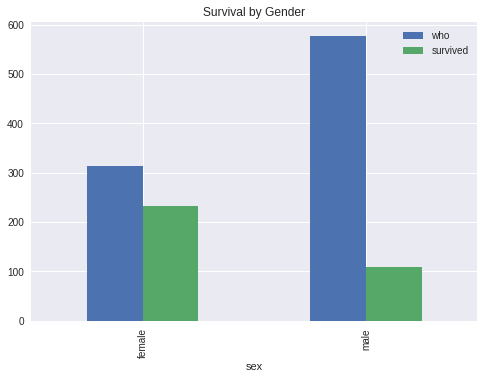

In [3]:
# Pivot the data (group by) and perform aggregations (sum, count) on the data, visualize the result with a bar plot:
_ = titanic_data_frame.groupby('sex').agg({'survived': 'sum', 'who': 'count'}).plot.bar(title='Survival by Gender')

**Exercise 2:** Demonstrate reationship between `class` and `survived` using a bar chart.  Fill in the missing labels:


In [0]:
# This cell will throw an error if you don't replace the <values> below:
exercise2 = titanic_data_frame.groupby('<replace with groupby target>').agg({   # what do we want on our x-axis?
      'survived': '<replace with agg method>',                                  # how many people survived?
      'who': '<replace with agg method>'                                        # how many people where there to begin with?
  }).plot.bar(title='Survival by Class')

## Translate GA Observations into SQL Code
We want to use BigQuery to extract our data and download that data into our Python Notebook. We'll then use Python libraries (ie. Pandas, NumPy) to further analyze and visualize the data. Finally, we'll apply machine learning to that data and analyze those results.

### First, authenticate your Notebook with Google Cloud:

In [0]:
from google.colab import auth
auth.authenticate_user()

<h3>Getting Familiar with BigQuery in Python</h3>
<h4>The `%%magic` of BigQuery and Google Colaboratory</h4>

Magic command which runs a query and displays the result, optionally saving it to a variable as a `DataFrame`.
```
    %%bigquery [<destination_var>] [--project <project>] [--use_legacy_sql] [--verbose]
    <query>
 ```

In [5]:
# This example query is saved to a DataFrame called `df`
%%bigquery df --project analyticspros.com:spotted-cinnamon-834 --verbose
SELECT name, SUM(number) as count
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY name
ORDER BY count DESC
LIMIT 5

Executing query with job ID: 1ae4249d-5a32-4833-9c08-347fbe54c375
Query executing: 0.55s
Query complete after 0.77s


,name,count
0,James,5001762
1,John,4875934
2,Robert,4743843
3,Michael,4354622
4,William,3886371


###Querying the `ga_sessions_*` tables
<img src="https://www.strunkmedia.com/wp-content/uploads/2018/01/google-analytics.png" width="300px">  
Before we get to building a query to use in our clustering analysis, we're going to review some of the basics around the BigQuery GA Export Schema:  
**GA Support Article:** https://support.google.com/analytics/answer/3437719?hl=en  
**Luna Metrics BQ Recipes:** https://www.lunametrics.com/labs/bigquery-recipes/  
**Analytics Pros Cookbook:** *(outdated)* https://www.analyticspros.com/wp-content/uploads/2016/11/AP_BigQuery-Cheat-Sheet_Web-Format.pdf   
**Luka's BQ Challenge:** https://colab.research.google.com/drive/18TBZ_EWmaLEx4RMe5GL5S6drhC9eGF6e 

**Example fields from the GA Export Schema:**  

    fullVisitorId        STRING	    The unique visitor ID (also known as client ID)
    totals	           RECORD	    This section contains aggregate values across the session.
    visitStartTime	   INTEGER	   The timestamp (expressed as POSIX time).
    date	             STRING	    The date of the session in YYYYMMDD format. 
    channelGrouping  	STRING	    The Default Channel Group associated with an end user's session for this View.
    

[GA Channel data for 2017-08-01](https://analytics.google.com/analytics/web/?utm_source=demoaccount&utm_medium=demoaccount&utm_campaign=demoaccount#/report/acquisition-channels/a54516992w87479473p92320289/_u.date00=20170801&_u.date01=20170801/)

<img src='https://storage.googleapis.com/pats-test/clustering/ga_20170801_channel_data.png' width='700px'>

**NOTICE:** You'll see a discrepancy between GA and BigQuery using the Google Merchandise Store dataset. This is due to anonmization that occured in making the `ga_session_` data public. When you are working in production on behalf of your clients you want exact pairity between GA and BigQuery.

In [6]:
# Select users, new users, and sessions by channel from GA Public Dataset:
%%bigquery df --project analyticspros.com:spotted-cinnamon-834
SELECT
  channelGrouping AS channel,
  COUNT(DISTINCT fullVisitorId) AS users,
  SUM(totals.newVisits) as newUsers,
  SUM(totals.visits) AS sessions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
GROUP BY
  channel
ORDER BY users DESC

,channel,users,newUsers,sessions
0,Organic Search,1267,1096,1346
1,Referral,368,190,436
2,Direct,355,302,400
3,Social,207,189,213
4,Paid Search,61,40,70
5,Affiliates,49,42,52
6,Display,30,13,39


In [7]:
# The result of the query was saved into the `DataFrame` named `df`
# Print the sum totals for these three columns:
df[['users', 'newUsers', 'sessions']].sum()

users       2337
newUsers    1872
sessions    2556
dtype: int64

### Building Clustering SQL Code - using `fullVisitorId`
Clustering Analysis is performed on users, and to perform analysis on users we need to structure our SQL queries to return data (features) by a user. In the GA Export Schema, a user is most simply represented by the `fullVisitorId` field. User data would be representated as each row having a distinct `fullVisitorId` and subsequent columns are aggregate metrics/dimensions for that specific user.

In [8]:
%%bigquery first_clustering_df --project analyticspros.com:spotted-cinnamon-834
SELECT
  fullVisitorId,
  SUM(totals.pageviews) AS pageviews,
  SUM(totals.totalTransactionRevenue / 1e6) AS revenue
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`                  -- ga_sessions_* will return all dates, be sure to use _TABLE_SUFFIX BETWEEN X AND Y to limit output
WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170707'                           -- set a date range using _TABLE_SUFFIX BETWEEN '<YYYYMMDD>' AND '<YYYYMMDD>'
GROUP BY fullVisitorId                                                          -- aggregate all results by `fullVisitorId`
HAVING revenue < 500                                                            -- remove outliers,  only return results for users with less than $500 in revenue
ORDER BY revenue DESC                                                           -- order results by revenue, descending
LIMIT 10                                                                        -- limit results to keep analysis simple

,fullVisitorId,pageviews,revenue
0,4068416534578096540,33,392.54
1,8197879643797712877,100,382.94
2,4352760646905266733,38,381.54
3,1675171647898452800,16,340.92
4,5772921781547143127,41,324.90
5,454845221896711463,18,267.70
6,4140559214164857738,34,252.66
7,8151349247637576196,29,248.29
8,4708133624098231997,39,247.92
9,4957622252319100547,26,242.85


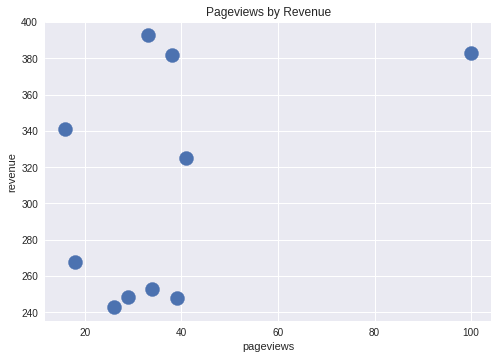

In [9]:
data = first_clustering_df.drop('fullVisitorId', axis=1)                                           # create new object, `data`, wit the `fullVisitorId` removed
_ = data.plot.scatter('pageviews', 'revenue',s=200, title='Pageviews by Revenue') # scatter plot the `data` object using `pageviews` vs `revenue`

### Your First Clustering Algorithm
<img src='https://storage.googleapis.com/pats-test/clustering/clustering_algorithm.png' width='550px'>  
**Exercise 3:** Adjust the slider below to change the value of `k`. Changing the value of `k` will change how many clusters are created.  
>1) Try to predict the clusters in advance of them being calculated, did you predictions lineup with the result?  
>2) Analyze the code to understand how we initialize the `kmeans` object and then generate cluster assignments.  
>> i. What is the role of the `sklearn.cluster.KMeans` library?  
>> ii. What is the role of the `matplotlib.pyplot` library?  
>> iii. What is the maximum number of clusters you can generate for this data?

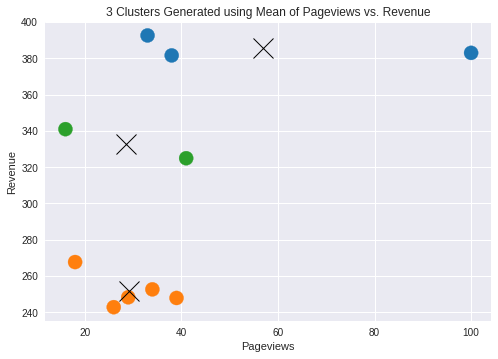

In [10]:
#@title k-Means Clustering on Simple Dataset { run: "auto", vertical-output: true, form-width: "600px" }

# k = number of clusters that are generated by the K-Means Algorithm
k = 3 #@param {type:"slider", min:1, max:10, step:1}

# import relevant libraries
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# run clustering algorithm on dataset
kmeans = KMeans(n_clusters=k).fit(data)                                         # generate `k` clusters using 2-dimensional input dataframe
first_clustering_df['cluster'] = kmeans.predict(data)                           # add cluster assignments to the `df` object as df['cluster']

#plot results of cluster assignments to scatter plot
fig, ax = plt.subplots()
colors = plt.cm.tab10.colors                                                    # use the matplotlib colormap array called `tab10`
ax.scatter(                        
    first_clustering_df['pageviews'],                                           # x=data['pageviews']
    first_clustering_df['revenue'],                                             # y=data['revenue']
    c=first_clustering_df["cluster"].apply(lambda x: colors[x]),                # color the values based on data['cluster'] assignment
    s=200                                                                       # size (s) the scatter points to be `200` points
)

# add center points to plot
for i in kmeans.cluster_centers_:                                               # for each cluster in the kmeans object, get the center points
  ax.plot(i[0], i[1], 'x', markersize=20, markeredgewidth=1, color='black')     # add the cluster center points to the plot as a black X     

# add labels to the plot  
plt.xlabel('Pageviews')
plt.ylabel('Revenue')
plt.title('{} Clusters Generated using Mean of Pageviews vs. Revenue'.format(k))# dynamically title the chart using, including the value of `k`

# print the plot
plt.show()

### Combing `hit` and `session` features for `fullVisitorId` data
It is time to add the 5+ business observations you made to your SQL query. This will give our clustering algorithm the ability to factor in those data features into the model that is generated and used to assign clusters to users. We will then be able to analyze that output and assign business labels to those users.

**First, recall your business observations:**

In [11]:
for i in exercise1.keys():
  print i,exercise1[i]

1 
2 
3 
4 
5 


<h4>Converting Business Observations into SQL Code:</h4>
It is highly likely that your observations described  user behaviors that occured within sessions. For example, an observation like `'Users who purchased a nest product generated high revenue'` would require us to tap into session level behavior (ie. purchasing a Nest) and aggreate that to the user level.  

Our goal is to understand the behaviors that lead to a conversion. We would rephrase this observation in another way: `'Do users who view Nest products generate higher revenue on the website?'` This form of the question will be more informative and let the data to most of the talking in clustering.

We can express this question in SQL form as the following:

    SELECT 
          fullVisitorId, 
          totals.totalTransactionRevenue / 1e6 as revenue,
          SUM(IF(hits.page.pagePath LIKE "/google+redesign/nest%" AND hits.type = "PAGE", 1, 0)) as nest_views
    FROM project.dataset.table_<date>, UNNEST(hits) as hits
    GROUP BY fullVisitorId, totals.totalTransactionRevenue

In [12]:
%%bigquery example_sql --project analyticspros.com:spotted-cinnamon-834
WITH session_data AS (
  SELECT 
    fullVisitorId, 
    totals.totalTransactionRevenue / 1e6 as revenue, 
    totals.visits as sessions,
  SUM(IF(hits.page.pagePath LIKE "/google+redesign/nest%" AND hits.type = "PAGE", 1, 0)) as nest_views
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, unnest(hits) as hits   
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170731'
  GROUP BY 1,2,3
)
SELECT                                                                          -- The `data` query returns one row per session, we need to aggregate to have one row per user, returning user scoped results
  fullVisitorId,                                                                
  SUM(sessions) as total_sessions,                                              -- Use SUM() when we need to aggregate a `totals_*` metric, meaning total number of X observed by user 
  AVG(nest_views) as nest_views_per_session,                                    -- Use AVG() or STD() when we need to aggregate a `per session` metric, meaning [AGG()] of X observed by user over their sessions
  AVG(revenue) as revenue_per_session
FROM session_data
GROUP BY fullVisitorId                                                          -- This final `group by fullVisitorId` will condense multiple sessions into one row
HAVING (revenue_per_session > 0 and nest_views_per_session > 0)                 -- Having clause is only here to highlight example of high value visitors
ORDER BY nest_views_per_session DESC

,fullVisitorId,total_sessions,nest_views_per_session,revenue_per_session
0,7567817112637547239,3,0.666667,146.58
1,6968323948324124881,2,0.500000,28.99
2,0143782636543876435,2,0.500000,78.98
3,3221924345288041502,2,0.500000,13.80
4,5962830800899970265,2,0.500000,29.79
5,081281456829886913,2,0.500000,81.71


**Exercise 4:** Now you have an example of how to aggregate session based behaviors into a user scoped result. 
>1) Incorporate your remaining observations into your SQL query by adding to the example below  
>2) Decide for each metric whether to aggregate it as a `totals` or `per session` scoped value  
>3) Add as many `totals RECORD` fields as is relevant, in addition to site behavior metrics  
>4) *BONUS POINTS:* Incorporate a custom dimension or event into your SQL query

In [0]:
%%bigquery exercise4 --project analyticspros.com:spotted-cinnamon-834
WITH session_data AS (
  SELECT 
    fullVisitorId, 
    totals.totalTransactionRevenue / 1e6 as revenue, 
    totals.visits as sessions,
    SUM(IF(hits.page.pagePath LIKE "/google+redesign/nest%" AND hits.type = "PAGE", 1, 0)) as nest_views,
  
  --  ADD MORE SESSION METRICS
  
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, unnest(hits) as hits   
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170707'                         -- adjust date range as needed; for final use '20160801' through '20170801'
  AND ( device.deviceCategory in ("desktop", "tablet"))                         -- assumption that desktop/tablet are drastically different experiences than mobile 
  GROUP BY 1,2,3, -- ADD MORE SESSION GROUP BY FIELDS
)
SELECT 
  fullVisitorId,                                                                
  SUM(sessions) as total_sessions,
  AVG(nest_views) as nest_views_per_session,
  AVG(revenue) as revenue_per_session,
  
  -- AGGREATE SESSION METRICS TO USER LEVEL
  
  
FROM session_data
GROUP BY fullVisitorId

#### Spoiler: Answer

In [0]:
%%bigquery exercise4 --project analyticspros.com:spotted-cinnamon-834

WITH session_data AS (
  SELECT 
    fullVisitorId, 
    
    totals.transactions as transactions,
    totals.totalTransactionRevenue / 1e6 as revenue, 
    totals.visits as sessions,
    totals.timeOnSite as time_on_site,
    totals.pageviews as pageviews,
    totals.hits as ga_hits,
    totals.sessionQualityDim as session_quality,

    SUM(IF(hits.page.pagePath LIKE "/google+redesign/nest%" AND hits.type = "PAGE", 1, 0)) as nest_views,
    SUM(IF(hits.page.pagePath LIKE "/google+redesign/apparel%" AND hits.type = "PAGE", 1, 0)) as apparel_views,
    SUM(IF(hits.page.pagePath LIKE "/google+redesign/bags%" AND hits.type = "PAGE", 1, 0)) as bag_views,
    SUM(IF(hits.page.pagePath LIKE "/google+redesign/office%" AND hits.type = "PAGE", 1, 0)) as office_views,
    SUM(IF(hits.page.pagePath LIKE "/google+redesign/accessories%" AND hits.type = "PAGE", 1, 0)) as accessory_views
    
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, unnest(hits) as hits   
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170731'                         -- adjust date range as needed; for final use '20160801' through '20170801'
  AND ( device.deviceCategory in ("desktop", "tablet"))                         -- assumption that desktop/tablet are drastically different experiences than mobile 
  GROUP BY 1,2,3,4,5,6,7,8
)

SELECT 
  fullVisitorId,                                                                
  SUM(sessions) as total_sessions,
  SUM(transactions) as total_transactions,
  SUM(revenue) as total_revenue,
  AVG(session_quality) as avg_session_quality,
  AVG(pageviews) as avg_pageviews,
  AVG(time_on_site) as avg_time_on_site,
  AVG(ga_hits) as avg_hits,
  AVG(nest_views) as avg_nest_views,
  AVG(apparel_views) as avg_apparel_views,
  AVG(bag_views) as avg_bag_views,
  AVG(office_views) as avg_office_views,
  AVG(accessory_views) as avg_accessory_views
 
FROM session_data
GROUP BY fullVisitorId

### Analyze Results of SQL Query

In [15]:
# Replace `NaN` (Not a Number) values with a 0,  print DataFrame statistics:
exercise4.fillna(0,inplace=True)
exercise4.describe()

,total_sessions,total_transactions,total_revenue,avg_session_quality,avg_pageviews,avg_time_on_site,avg_hits,avg_nest_views,avg_apparel_views,avg_bag_views,avg_office_views,avg_accessory_views
count,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000,38966.000000
mean,1.187856,0.025099,3.948443,3.779189,3.691010,147.258517,4.397414,0.004615,0.655778,0.300583,0.165647,0.224140
std,0.722410,0.181490,216.994764,10.986770,5.581502,356.206540,7.682810,0.086259,1.880140,1.094876,0.833577,0.833638
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,2.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,4.000000,116.000000,4.000000,0.000000,0.666667,0.000000,0.000000,0.000000
max,31.000000,9.000000,41810.850000,96.000000,122.000000,8369.000000,170.000000,8.000000,62.000000,28.000000,44.000000,16.000000


## Data Preparation for Machine Learning
### Data Standardization
<img src='http://scikit-learn.org/stable/_images/sphx_glr_plot_all_scaling_002.png' width='700'>  
As we can see from the statistics graph above, our data is wildly varied and tends to have the distribution skew close to zero. The data also has outliers, zero values, and originally had null values. These are all things that can impact the utility of machine learning processing, so we account for this with preparation.  

A very simple first step to preparing your data for machine learning is to apply `Standardization`. This process attempts to scale the values to be normally distributed, with the mean sitting as close to zero as possible. We need to do this for all features in the data, thankfully there are ML Libraries to make this easy.
                                                                                                    
                                                                                                    


In [16]:
from sklearn.preprocessing import StandardScaler
data_cluster = exercise4.drop('fullVisitorId', axis=1)

standard_scaler = StandardScaler()
stand_scaled = standard_scaler.fit_transform(data_cluster)
std_exercise4 = pd.DataFrame(stand_scaled, columns=data_cluster.columns)

std_exercise4.describe()

,total_sessions,total_transactions,total_revenue,avg_session_quality,avg_pageviews,avg_time_on_site,avg_hits,avg_nest_views,avg_apparel_views,avg_bag_views,avg_office_views,avg_accessory_views
count,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04,3.896600e+04
mean,-1.400444e-16,5.835181e-18,-1.458795e-18,-1.167036e-17,-1.633851e-16,4.668145e-17,8.169254e-17,-3.646988e-18,-7.002218e-17,-7.002218e-17,1.750554e-17,-2.334073e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.600442e-01,-1.382948e-01,-1.819626e-02,-3.439807e-01,-4.821363e-01,-4.134130e-01,-4.422155e-01,-5.350200e-02,-3.487968e-01,-2.745402e-01,-1.987211e-01,-2.688735e-01
25%,-2.600442e-01,-1.382948e-01,-1.819626e-02,-2.529610e-01,-4.821363e-01,-4.134130e-01,-4.422155e-01,-5.350200e-02,-3.487968e-01,-2.745402e-01,-1.987211e-01,-2.688735e-01
50%,-2.600442e-01,-1.382948e-01,-1.819626e-02,-2.529610e-01,-3.029707e-01,-3.965686e-01,-3.120531e-01,-5.350200e-02,-3.487968e-01,-2.745402e-01,-1.987211e-01,-2.688735e-01
75%,-2.600442e-01,-1.382948e-01,-1.819626e-02,-2.529610e-01,5.536032e-02,-8.775504e-02,-5.172838e-02,-5.350200e-02,5.791268e-03,-2.745402e-01,-1.987211e-01,-2.688735e-01
max,4.126817e+01,4.945185e+01,1.926657e+02,8.393913e+00,2.119689e+01,2.308168e+01,2.155523e+01,9.269118e+01,3.262789e+01,2.529947e+01,5.258650e+01,1.892436e+01


## Applying K-Means to GA Data

In [17]:
# run clustering algorithm on dataset
k = 5

# apply k-means to StandardScaled dataframe:
std_kmeans = KMeans(n_clusters=k).fit(std_exercise4)                                         
exercise4['std_cluster'] = std_kmeans.predict(std_exercise4)  

# print the populations of each cluster assignment:
print exercise4.std_cluster.value_counts()

4    32916
0     4604
1      784
3      661
2        1
Name: std_cluster, dtype: int64


*Note:* The StandardScaler() could be disproportionately influenced by outliers, we'll deal with outliers a bit later in the notebook. In our case, when a cluster consists of a single user, we might consider that an outlier. 

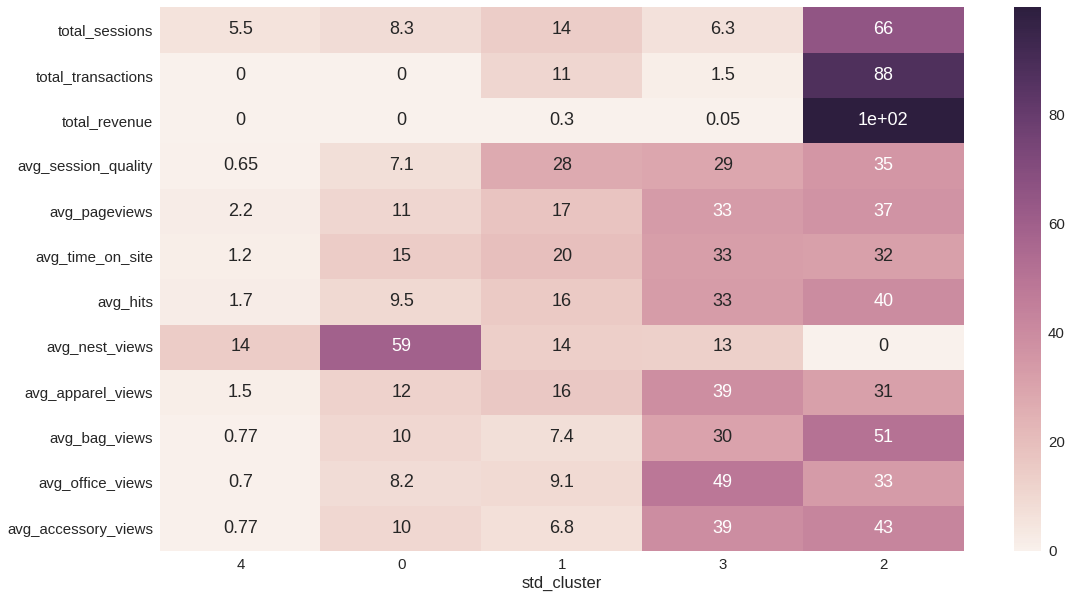

In [18]:
analysis_df = exercise4.groupby('std_cluster').mean().apply(lambda x: (x / x.sum().astype(float))*100).round(2)
analysis_df['cluster_population'] = pd.DataFrame(exercise4.std_cluster.value_counts()).sort_index()['std_cluster']
analysis_df = analysis_df.sort_values(by='cluster_population',ascending=False)

import seaborn as sns
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(18,10))         
_ = sns.heatmap(analysis_df.drop('cluster_population',axis=1).transpose(), annot=True, ax=ax)

### Dealing with Outliers
There is a cluster being generated that consists of one user, and it makes up the lionshare of revenue and other metrics in our `analysis_df`.  
We need to remove these outlier values in order to generate more representative cluster groups. To do this, we'll first analyze our query result data.

In [19]:
rm_outliers = exercise4.drop('std_cluster', axis=1)
for i in rm_outliers.columns:
  if i not in ['fullVisitorId']:
    rm_outliers = rm_outliers[rm_outliers[i] <= rm_outliers[i].quantile(.9999)]
print "removed {} outliers from the source data".format(len(exercise4) - len(rm_outliers))

removed 37 outliers from the source data


In [20]:
# run clustering algorithm on dataset
k = 5

data_cluster = rm_outliers.drop('fullVisitorId', axis=1)

rm_outlier_scaled = standard_scaler.fit_transform(data_cluster)
std_rm_outlier = pd.DataFrame(rm_outlier_scaled, columns=data_cluster.columns)

# apply k-means to StandardScaled dataframe:
std_kmeans = KMeans(n_clusters=k).fit(std_rm_outlier)                                         
rm_outliers['std_cluster'] = std_kmeans.predict(std_rm_outlier)  

# print the populations of each cluster assignment:
print rm_outliers.std_cluster.value_counts()

1    32344
0     4905
4      791
2      771
3      118
Name: std_cluster, dtype: int64


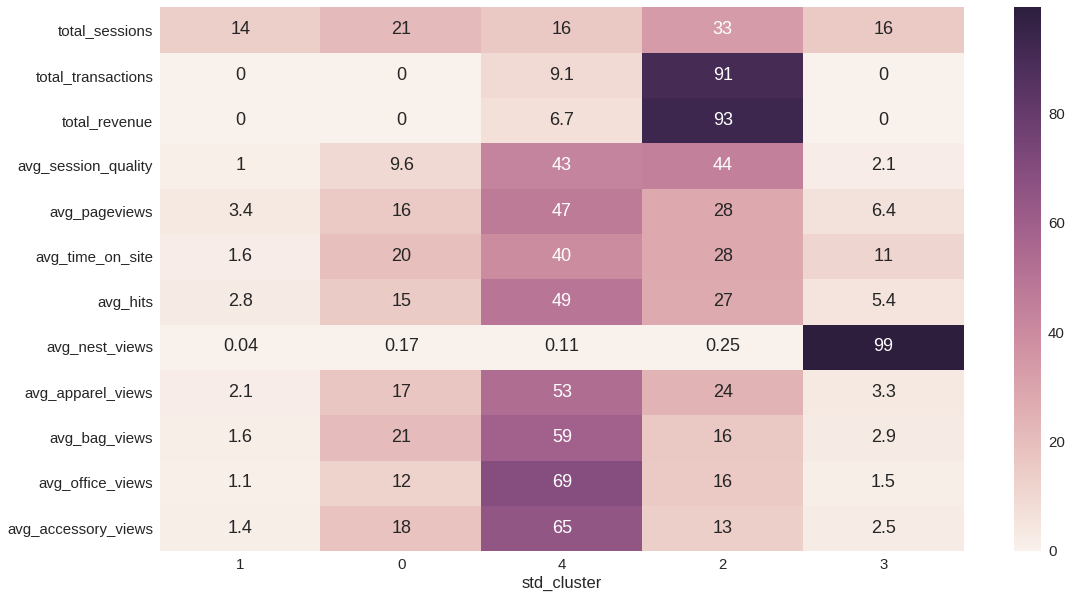

In [21]:
analysis2_df = rm_outliers.groupby('std_cluster').mean().apply(lambda x: (x / x.sum().astype(float))*100).round(2)
analysis2_df['cluster_population'] = pd.DataFrame(rm_outliers.std_cluster.value_counts()).sort_index()['std_cluster']
analysis2_df = analysis2_df.sort_values(by='cluster_population',ascending=False)

import seaborn as sns
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(18,10))         
_ = sns.heatmap(analysis2_df.drop('cluster_population',axis=1).transpose(), annot=True, ax=ax)

In [22]:
rm_outliers.describe()

,total_sessions,total_transactions,total_revenue,avg_session_quality,avg_pageviews,avg_time_on_site,avg_hits,avg_nest_views,avg_apparel_views,avg_bag_views,avg_office_views,avg_accessory_views,std_cluster
count,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000,38929.000000
mean,1.186082,0.024224,2.487544,3.741539,3.649060,145.482919,4.334221,0.004311,0.647241,0.295618,0.162218,0.220151,0.960826
std,0.698444,0.170388,33.442675,10.880327,5.327235,346.488263,7.244055,0.073453,1.806247,1.057700,0.786096,0.805492,0.582472
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,1.000000,2.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,4.000000,116.000000,4.000000,0.000000,0.666667,0.000000,0.000000,0.000000,1.000000
max,16.000000,4.000000,2218.100000,94.000000,89.000000,5384.000000,127.000000,3.000000,34.000000,21.000000,21.000000,15.000000,4.000000
